## Learning Outcomes
1. Image Histogram : distributions of grayscale values 
2. Enhance the contrast : scalar multiplication on image, historgram equalization and its variant called CLANE.
3. Thresholding: global thresholding and otsu tresholding
4. Morphological operations (limit our discussion on binary image)
5. Color spaces :  HSV color space used to perform color based segmentation.

# Setup

In [1]:
import sys
assert sys.version_info >=(3,7)

import cv2 as cv
import numpy as np
from util_func import *

 ## Image histogram
 
 Purpose : 
 1. Know the distribution of grayscale values / pixel
 2. Use case:
     - histogram equalization
         - help to enhance contrast
         - normally done before edge detection
         - probability density function
     - build image (color histogram) search engine

Google : detect low contrast and high contrast image

In [2]:
img = cv.imread("images/lena.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [3]:
# There are 2 ways to compute histogram
%timeit hist = cv.calcHist([gray], [0], None, [256], [0, 256]) # 256 bins
%timeit hist, _ = np.histogram(gray.flatten(), 256)

22 µs ± 20.1 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
335 µs ± 5.12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


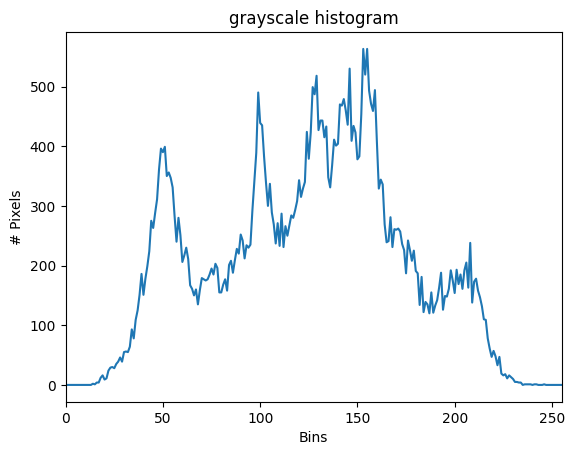

In [4]:
hist = cv.calcHist([gray], [0], None, [256], [0, 256])

plt.figure()
plt.title("grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# Pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

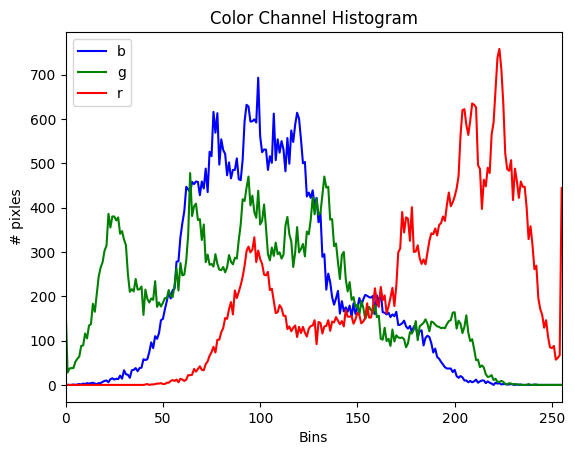

In [5]:
# get the histogram for every channel
channels = cv.split(img)
colors = ("b", "g", "r")

plt.figure()
plt.title("Color Channel Histogram")
plt.xlabel("Bins")
plt.ylabel("# pixles")

for ch, color in zip (channels, colors):
    hist = cv.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color, label = color)

plt.xlim([0, 255])
plt.legend()
plt.show()

In [6]:
img = cv.imread("images/low_contrast_img.jfif", 0)
show_img("low contrast", img)

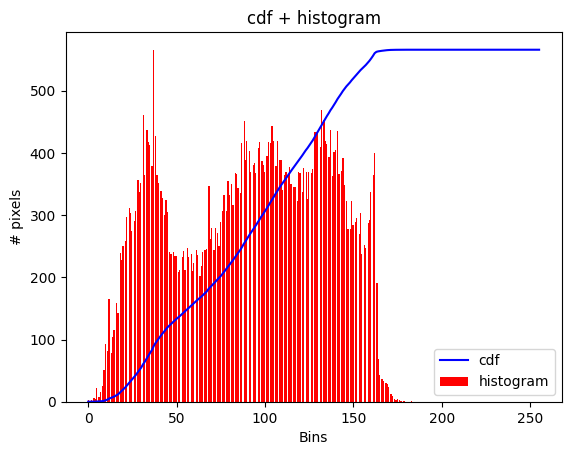

In [7]:
# histogram for this image
hist = cv.calcHist([img], [0], None, [256], [0, 256])

#cummulative distribution function (cdf)
cdf = hist.cumsum()
cdf_norm = cdf * hist.max()/ cdf.max()

plt.figure()
plt.plot(cdf_norm, color = "b")
plt.hist(img.flatten(), 256, color = "r")
plt.title("cdf + histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf", "histogram"))
plt.show()

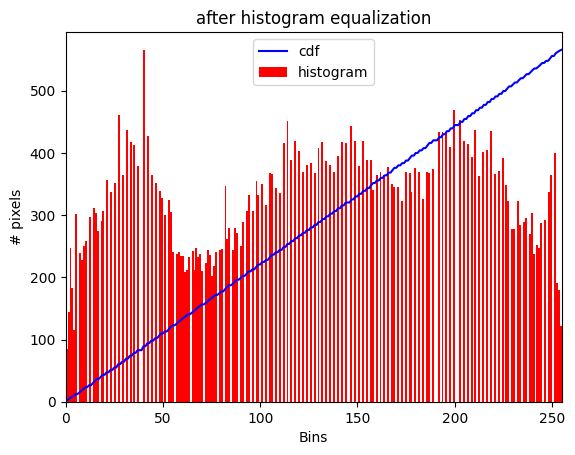

In [8]:
# Histogram Equalization
eq = cv.equalizeHist(img)

hist = cv.calcHist([eq], [0], None, [256], [0, 256])
cdf = hist.cumsum()
cdf_norm = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color = "b")
plt.hist(eq.flatten(), 256, color = "r")
plt.title("after histogram equalization")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf", "histogram"))
plt.xlim([0, 255])
plt.show()

In [9]:
#CLAHE
img = cv.imread("images/dog1.jfif", 0)

#equalization
eq = cv.equalizeHist(img)
#CLAHE
clahe = cv.createCLAHE(clipLimit = 3, tileGridSize = (8, 8))
dst = clahe.apply(img)

cv.imshow("Original", img)
cv.imshow("equalization",eq)
cv.imshow("clahe", dst)
cv.waitKey(0)
cv.destroyAllWindows()

# Exercise 
Try histogram equalization and CLAHE on "winter.jfif" and display the results together with the original grayscale image. Comment on the results obtained.

In [10]:
# CLAHE
img_1 = cv.imread("images/winter.jfif", 0)

#equalization
eq = cv.equalizeHist(img_1)

#CLAHE
clahe = cv.createCLAHE(clipLimit = 3, tileGridSize = (8, 8))
dst = clahe.apply(img_1)

cv.imshow("Original", img_1)
cv.imshow("Equalization", eq)
cv.imshow("Clahe", dst)
cv.waitKey(0)
cv.destroyAllWindows()

## Thresholding

In [11]:
# simple global thresholding
#Difference types of thresholding
[i for i in dir(cv) if i.startswith("THRESH")] 

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [12]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype = np.uint8)

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)
    
    cv.imshow("window", np.vstack((img1, img2, img3, img4, img5)))
    
cv.namedWindow("window")
cv.createTrackbar("threshold", "window", 100, 255, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

## Simple globale threshold vs Otsu thresholding

In [13]:
img = cv.imread("images/noisy.jfif", 0)
show_img("noisy", img)

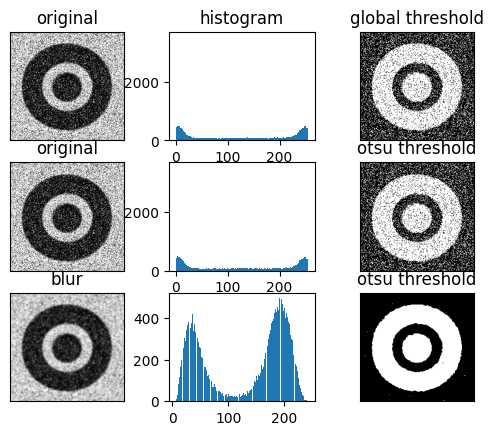

In [14]:
# apply 3 approaches :
#1. Global threshold
# 2. otsu threshold
# 3. blurring + otsu



#1:
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]

#2:
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

#3:
blur = cv.GaussianBlur(img, (5,5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1,
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold",
         "original", "", "otsu threshold",
         "blur", "", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256),  
    plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title = titles[3*i+2])

plt.show()

 ## Exercise 
 Plot the histogram of 'wood_plankck.jfif'. Then, apply thresholding to segment the wooden planck.

In [15]:
img_1 = cv.imread("images/wood_planck.jfif", 0)
show_img("Wood", img_1)

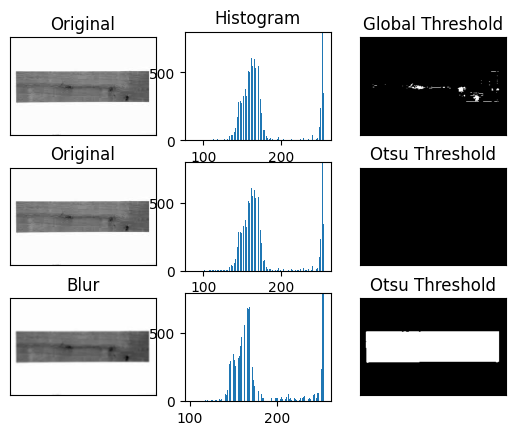

In [16]:
th4 = cv.threshold(img_1, 140, 255, cv.THRESH_BINARY_INV)[1]
th5 = cv.threshold(img_1, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_BINARY_INV)[1]
blur = cv.GaussianBlur(img_1, (5, 5), 0)
th6 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img_1, 0, th4,
        img_1, 0, th5,
        blur, 0, th6]

titles = ("Original", "Histogram", "Global Threshold",
          "Original", "", "Otsu Threshold",
          "Blur", "", "Otsu Threshold")

for i in range (3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*i])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256),
    plt.title(titles[3*i+1]), plt.ylim(0, 800)
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title=titles[3*i+2])
    
plt.show()

## Morphological Operations

1. Erosion
    - looks for neighbour of anchor point and changes from 255 to 0 (most centre point)
2. Dilation
    - looks for neighbour of anchor point and changes from 0 to 255 (most centre point)
3. Opening (Erosion + Dilation)
    - good for removing small white spots (noise)
    - purpose : break join
4. Closing (Dilation + Erosion)
    - purpose : fill in small hole

In [17]:
#kernel
kernel = np.ones((3,3), np.uint8)

#erosion
erosion = cv.erode(th3, kernel, iterations = 1)

#Combined
img_combined = np.hstack((th3, erosion))

show_img("erosion", img_combined)

In [18]:
#trackbar: function and while loop
def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while(1):
    #Retrieve the size and # iteration
    size  = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3
        
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
        
    kernel = np.ones((size, size), dtype = np.uint8)
    #closing
    closing = cv.morphologyEx(th3, cv.MORPH_CLOSE, kernel, iterations = iteration)
    
    cv.imshow(wn, closing)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()

In [19]:
cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

### Color Spaces
- RGB / BGR (prevalent image formats)
- HSV ( hue, saturation, value)
     * hue encodes color (angular, 0 - 359). In OpenCV, 0 - 179
     * saturation implies color purity (higher the value, the purier)
     * value : brightness. 0 is dark.
- L\*a\*b:
    - L denotes brightness /luminance while a and b are color channels.
    - perceptual uniformity

In [20]:
# sharpen
img = cv.imread("images/lena.jfif")

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

l, a, b = cv.split(img_lab)

#Process just the L channel
#sharpen
kernel = np.array([[0, -1, 0],[-1, 5, -1], [0, -1, 0]])
l_sharpen = cv.filter2D(l, -1, kernel)

#merge
sharpen = cv.merge((l_sharpen, a, b))

#change to bgr
sharpen = cv.cvtColor(sharpen, cv.COLOR_Lab2BGR)

cv.imshow("original", img)
show_img("sharpen", sharpen)

# Demo on color based segmentation

In [21]:
img = cv.imread("images/color_space/pant.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)


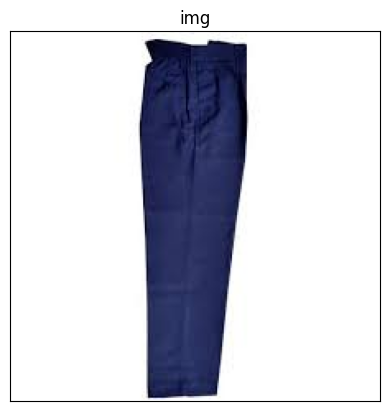

In [22]:
plt_img(img, "img")

In [23]:
## important depencies
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

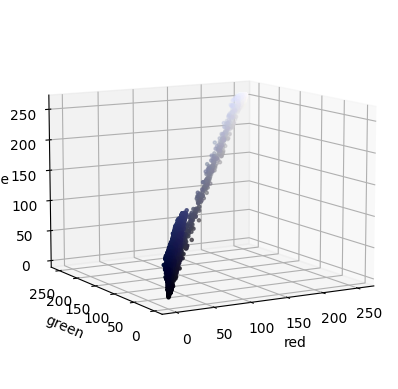

In [24]:
#split the image into separate channels
r, g, b = cv.split(img)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection = "3d")

#pixels colors ready as argument for scatter plot
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.ravel(), g.ravel(), b.ravel(),
            facecolors = pixel_colors, marker =".")
axis.view_init(elev = 10, azim = 240)
axis.set_xlabel("red")
axis.set_ylabel("green")
axis.set_zlabel("blue")
plt.show()

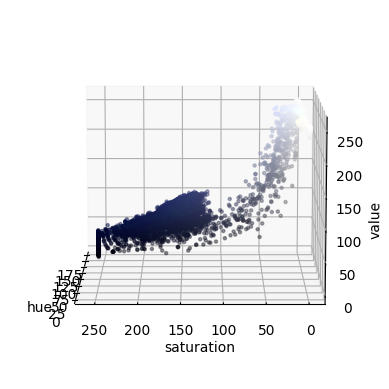

In [25]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection = "3d")

axis.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors = pixel_colors, marker =".")
axis.view_init(elev = 10, azim = 180)
axis.set_xlabel("hue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()

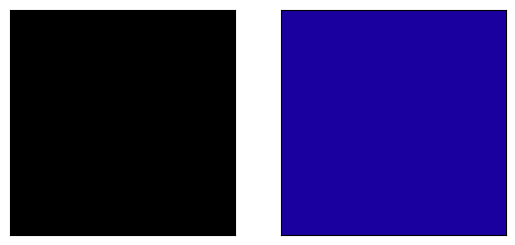

In [26]:
blue_low = (85, 90, 0)
blue_high = (125, 255, 160)

square1 = np.full((10, 10, 3), blue_low, dtype = np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype = np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))

plt.show()

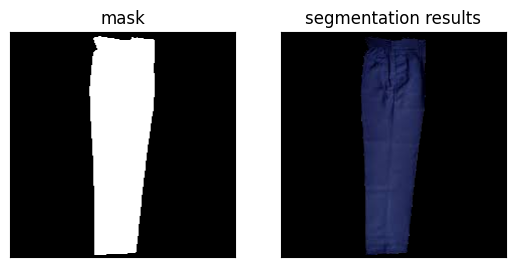

In [27]:
# color based segmentation
mask = cv.inRange(img_hsv, blue_low, blue_high)
res = cv.bitwise_and(img, img, mask = mask)
plt.subplot(121), plt_img(mask, title = "mask")
plt.subplot(122), plt_img(res, title = "segmentation results")

plt.show()

## Exercise

In [28]:
def color_seg(img, color_low, color_high, smooth = True):
    """Args:
    img: source image
    color_low and color_high are tuple of colors
    smooth is boolean (blurring or not)
    """
    
    ori_img = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
        #change from RGB to HSV
        img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
        
        #mask
        mask = cv.inRange(img_hsv, color_low, color_high)
        mask = cv.erode(mask, None, iterations = 2)
        mask = cv.dilate(mask, None, iterations = 2)
        
        return cv.bitwise_and(ori_img, ori_img, mask = mask)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/pant{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    
# perform color segmentation
res = [color_seg(im, blue_low, blue_high) for im in imgs]


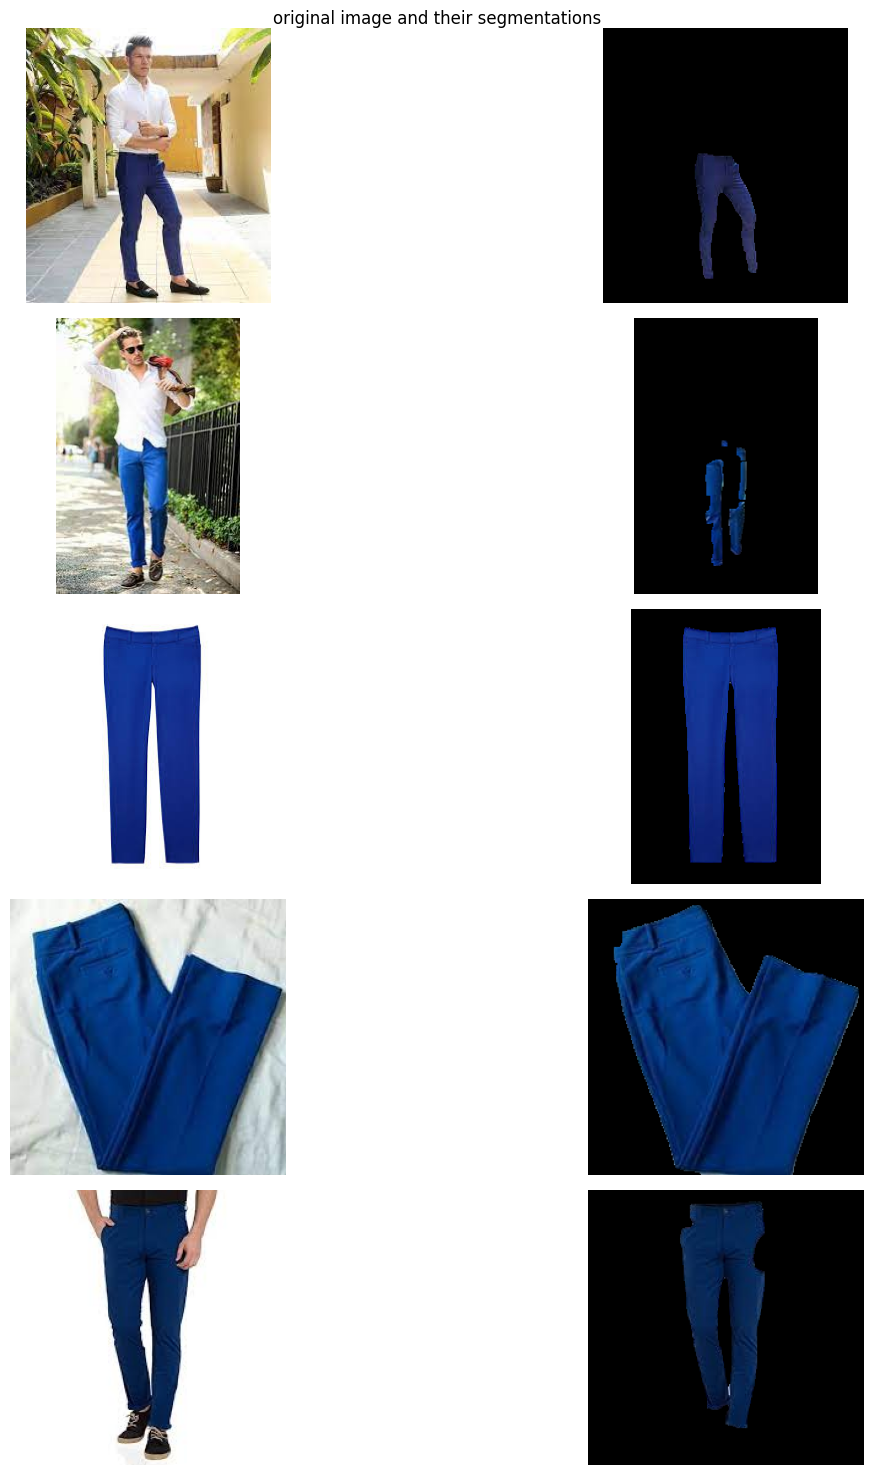

In [29]:
fig, ax = plt.subplots(5, 2, figsize = (15, 15))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("original image and their segmentations")  
plt.tight_layout()
plt.show()

## Weekly Activity

### Exercise 1
Write  aprogram to segment the boat and the poeple on it from the background. Follow the instruction below:
   - Use "boat.jpg" as input.
   - Apply Otsu thresholding
   - Draw bounding box to identify the region where the boat and people are located.

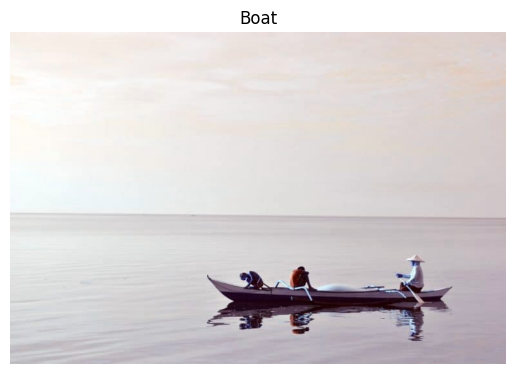

In [30]:
img = cv.imread("images/boat.jpg")

plt.imshow(img)
plt.title("Boat")
plt.axis("off")
plt.show()

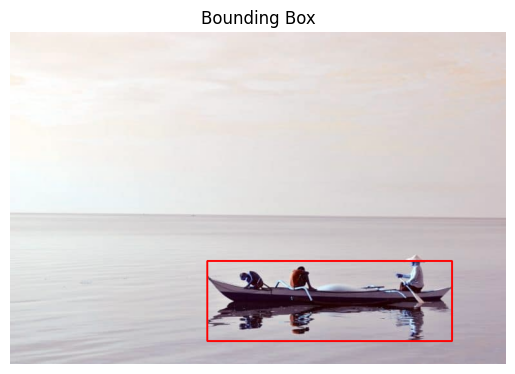

In [31]:
# Convert the image to grayscale
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# Apply Otsu Thresholding
thres = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

# Find the contours in the thresholded image
contours, _ = cv.findContours(thres, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest = max(contours, key=cv.contourArea)

# Get the bounding box of the largest contour
x,y,w,h = cv.boundingRect(largest)

cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# Display
plt.imshow(img)
plt.title("Bounding Box")
plt.axis("off")
plt.show()

### Exercise 2
Write a program to visualize the effect to size of structuring element on the morphological transformation (eg: erosion, dilation, opening, and closing).

   - Load the 'leaf.jfif' and perform thresholding to segment the leaf from the background.
   - Create a GUI containing trackbar to control the size of structuring element and display the resulting image on a window alongside the trackbar.

In [32]:
leaf = cv.imread("images/leaf.jfif")

show_img("Leaf", leaf)

In [33]:
gray = cv.cvtColor(leaf, cv.COLOR_RGB2GRAY)

# Apply thresholding to segment the leaf from the background
_, thres = cv.threshold(gray, 128, 255, cv.THRESH_BINARY_INV)

# Create a trackbar function
def trackbar (x):
    if x == 0: # make the minimum value of the trackbar starts from 1
        return
    
    # used in Morphological operations to define the shape and size of the neighbourhood around each pixel
    kernel_size = (x, x)  # Square structuring element with size x
    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    
    erosion = cv.erode(thres, kernel, iterations = 1)
    dilation = cv.dilate(thres, kernel, iterations = 1)
    opening = cv.morphologyEx(thres, cv.MORPH_OPEN, kernel)
    closing = cv.morphologyEx(thres, cv.MORPH_CLOSE, kernel)
    
    result = np.hstack((erosion, dilation, opening, closing))
    cv.imshow("window", result)
    
# Create a window and a trackbar
cv.namedWindow("window")
cv.createTrackbar("kernel size", "window", 1, 20, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

### Exercise 3
**Apply the steps shown in exercise 4** to segment the porcelain from these images:
<br>
"procelain1.jfif" - "procelain5.jfif"

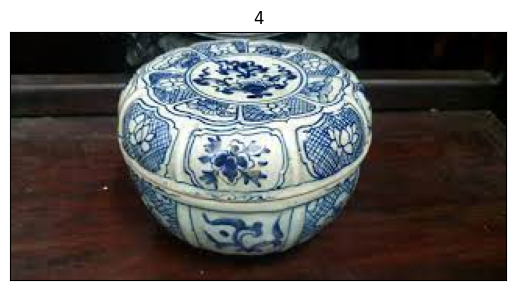

In [34]:
img = cv.imread("images/color_space/porcelain1.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt_img(img, cv.COLOR_BGR2RGB)

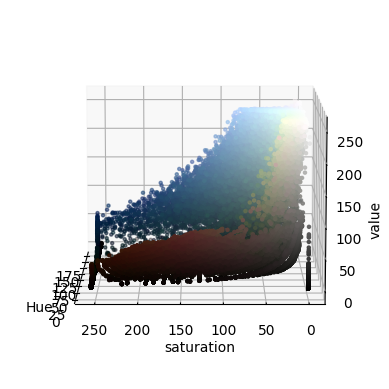

In [35]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
#set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

# pixel colors ready as argument for scatter plot
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10, azim=180)
axis.set_xlabel("Hue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()

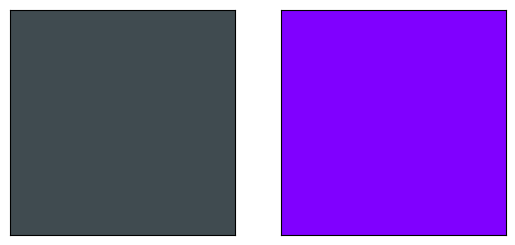

In [36]:
# Define lower and upper bounds for blue color in HSV
blue_low_1 = (100, 50, 80)
blue_high_1 = (135, 255, 255)

square1 = np.full((10, 10, 3), blue_low_1, dtype = np.uint8)
square2 = np.full((10, 10, 3), blue_high_1, dtype = np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

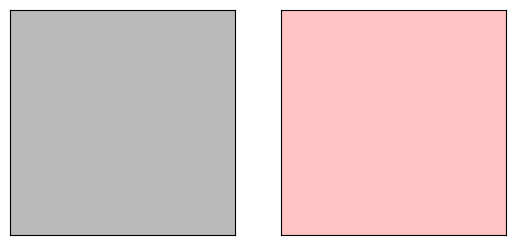

In [37]:
# Define lower and upper bounds for white color in HSV
white_low_1 = (0, 0, 185)
white_high_1 = (180, 60, 255)

square1 = np.full((10, 10, 3), white_low_1, dtype = np.uint8)
square2 = np.full((10, 10, 3), white_high_1, dtype = np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

In [38]:
def color_seg_1(img, color_low, color_high, color_low_1, color_high_1, smooth = True):
    """Args:
    img: source image
    color_low and color_high are tuple of colors
    smooth is boolean (blurring or not)
    """
    
    ori_img = img.copy()
    if smooth:
        #img = cv.GaussianBlur(img, (5, 5), 0)
        
        #change from RGB to HSV
        img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
        
        #mask
        mask_1 = cv.inRange(img_hsv, color_low, color_high)
        #mask_1 = cv.erode(mask_1, None, iterations = 1)
        #mask_1 = cv.dilate(mask_1, None, iterations = 1)
        
        mask_2 = cv.inRange(img_hsv, color_low_1, color_high_1)
        #mask_2 = cv.erode(mask_2, None, iterations = 1)
        #mask_2 = cv.dilate(mask_2, None, iterations = 1)
        
        # Combine the masks using logical OR
        combine = cv.bitwise_or(mask_1, mask_2)
        
        return cv.bitwise_and(ori_img, ori_img, mask = combine)


In [39]:
# img list
imgs_1 = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/porcelain{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs_1.append(img)
    
# Perform color segmentation
# result list
res = [color_seg_1(im, blue_low_1, blue_high_1, white_low_1, white_high_1) for im in imgs_1]

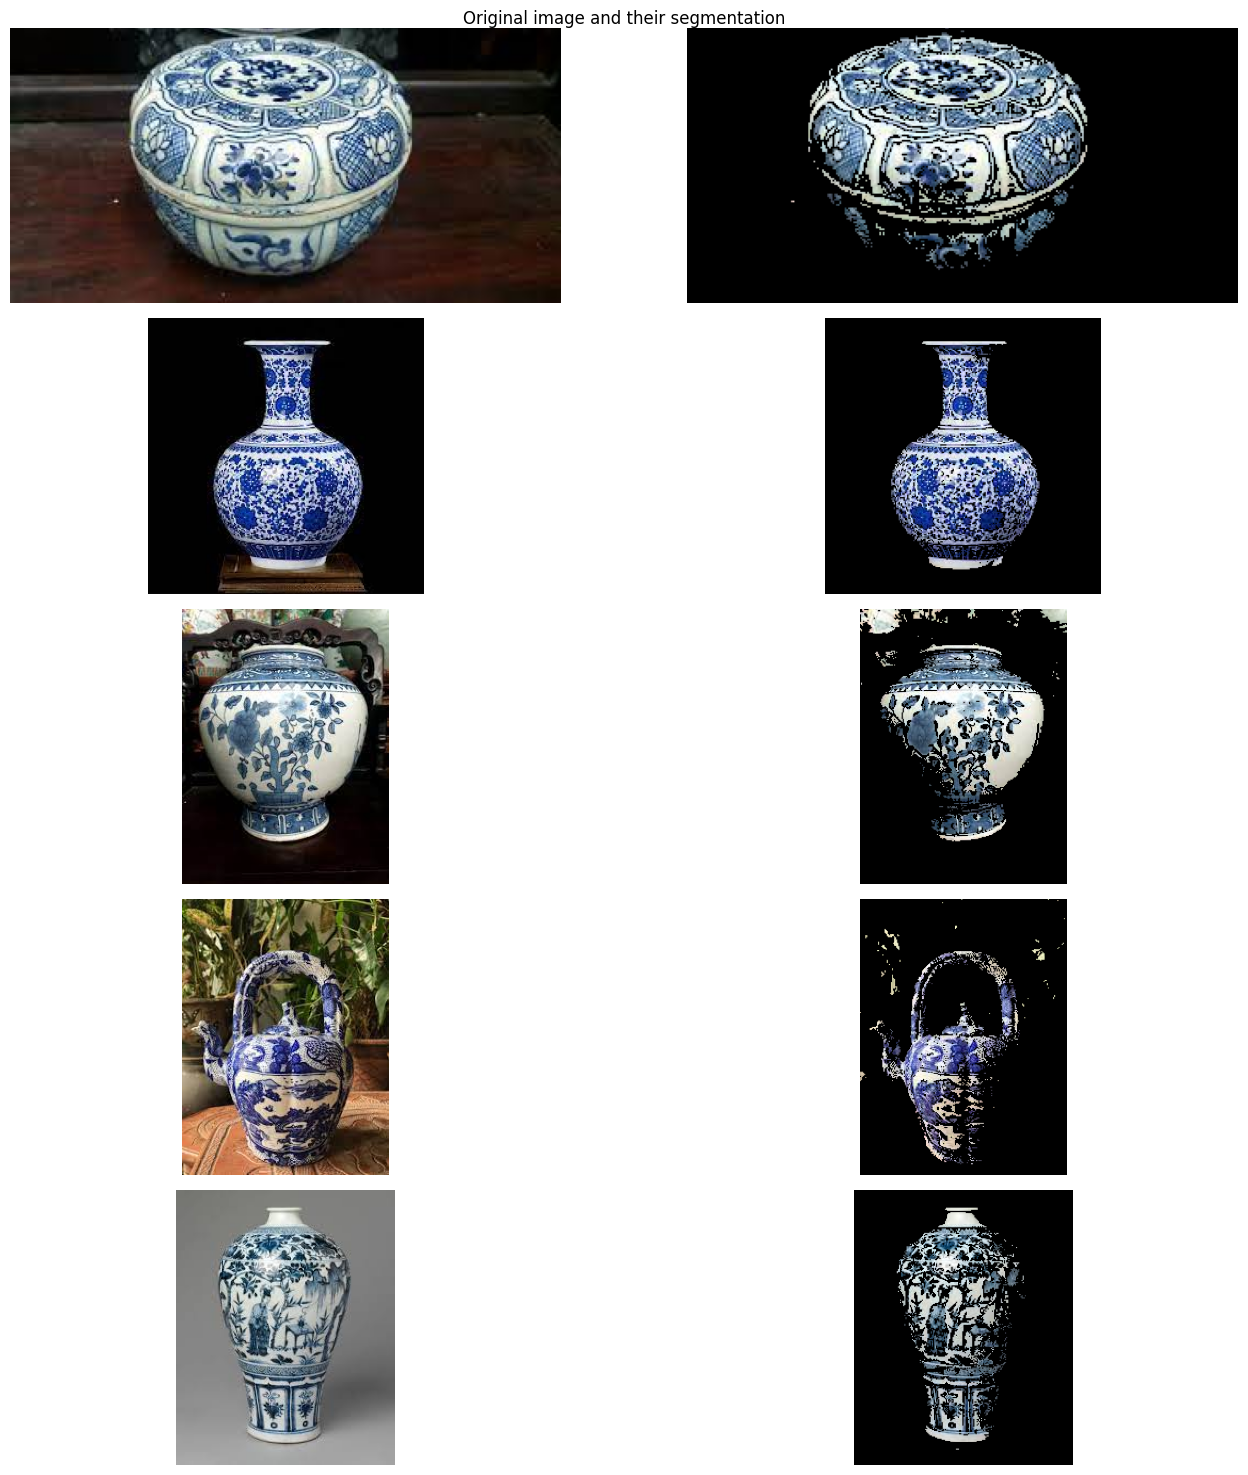

In [40]:
fig, ax = plt.subplots(5, 2, figsize = (15, 15))

for i in range(5):
    ax[i][0].imshow(imgs_1[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("Original image and their segmentation")
plt.tight_layout()
plt.show()